# Joining information from different files to be analysed together.

In [1]:
%matplotlib inline

In [2]:
import os
import sys
import re
import pandas as pd
import nltk
import matplotlib.pylab as plt
from matplotlib.ticker import FuncFormatter

sys.path.insert(0, "./modules")
import bs_preprocess
import get_df_analise_section

# Configuration

In [3]:
data_path = 'data'

ds_name = 'DOI_cited_science_1179052_retracted'
ds_label = ds_name

analysis_path = os.path.join(data_path, 'analysis')

# In
citing_tsv = os.path.join(analysis_path, '%s.tsv' % ds_name)
citing_prep_tsv = os.path.join(analysis_path, '%s_prep.tsv' % ds_name)

# Out
citing_sections_tsv = os.path.join(analysis_path, '%s_sections.tsv' % ds_name)
analysis_hist_tsv = os.path.join(analysis_path, '%s_hist_v2.tsv' % ds_name)

# Setup

In [4]:
# One time download required
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/deuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1.- ANALYSIS

•	Analyse file containing papers citing a particular DOI. This DOI can be read from a file (the one used in get_papers) or directly introduced in a list.
•	By calling get_df_analise_section it generates a dataframe containing:
    
    # df['cited_DOI', 'citing_DOI', 'reference_id', 'introduction_found', 
    #   'cited_in_introduction', 'maintext_found', 'cited_in_maintext', 
    #   'discussion_found', 'cited_in_discussion', 'conclusions_found', 
    #   'cited_in_conclusions', 'sentence_citing_intro', 
    #   'sentence_citing_maintext', 'sentence_citing_discussion', 
    #   'sentence_citing_conclusions']
    
-	reference_id is the number of reference of the cited paper in a particular paper. 
-	'introduction_found', 'maintext_found', 'discussion_found' and 'conclusions_found' get True/False value depending on whether a particular section has been found.
-	'cited_in_introduction', 'cited_in_maintext', 'cited_in_discussion', 'cited_in_conclusions' get True/False values depending on whether the paper is cited in these sections.
-	'sentence_citing_intro',  'sentence_citing_maintext', 'sentence_citing_discussion',    'sentence_citing_conclusions' are the sentences in each section where the paper is cited.


•	It also generates another dataframe with information about how many times the paper has been cited in each section: 

     # dict_citation_hyst ['DOI_cited', 'total_papers_citing', 'papers_all_sections_found',  
     #   'cited_in_introduction', 'cited_in_maintext', 'cited_in_discussion', 'cited_in_conlusions']

•	It saves the dataframes in two files. 
Note: For “df” only the information of the last paper (cited_DOI) analysed is saved 




In [5]:
list_df_analysis = []
list_citation_hyst = []

list_DOIs = ["10.1126/science.1179052"]
df_articles = pd.read_csv(citing_prep_tsv, sep='\t', encoding='utf-8')


for DOI in list_DOIs: 

    df_articles_citingDOI = df_articles[df_articles['DOI_cited'] == DOI]['article_citing']
    list_articles_citingDOI = df_articles_citingDOI.values.tolist()

    df = get_df_analise_section.get_df(DOI, list_articles_citingDOI)


    total_papers = df.shape[0]
    # mask1: sections found
    mask1 = (df['introduction_found'] == True) | ((df['discussion_found'] == True) | (df['conclusions_found'] == True))  

    # mask2: the reference is found at least in one section
    mask2 = (df['cited_in_introduction'] == True) | (df['cited_in_maintext'] == True) | (df['conclusions_found'] == True) | df['sentence_citing_conclusions'] == True
     
    mask = mask1 #& mask2
    
    papers_all_sections_found = df[mask].shape[0]    
    print("papers_all_sections_found:  ", papers_all_sections_found)

    found_in_percentages = (df[mask].select_dtypes(include=['bool']).sum() / papers_all_sections_found).to_dict()

    list_citation_hyst.append({
        'DOI_cited': DOI,  
       'total_papers_citing': total_papers,
       'papers_all_sections_found': papers_all_sections_found,
        **{
            k: found_in_percentages.get(k, 0)
            for k in {'cited_in_introduction', 'cited_in_maintext', 'cited_in_discussion', 'cited_in_conclusions'}
        }
    })

pd_citation_hyst = pd.DataFrame(list_citation_hyst) 


############### SAVING IN FILES #####################
df.to_csv(citing_sections_tsv, index=False, sep='\t', encoding='utf-8')
print('Wrote to:', citing_sections_tsv)

pd_citation_hyst.to_csv(analysis_hist_tsv, index=False, sep='\t', encoding='utf-8')
print('Wrote to:', analysis_hist_tsv)

papers_all_sections_found:   33
Wrote to: data/analysis/DOI_cited_science_1179052_retracted_sections.tsv
Wrote to: data/analysis/DOI_cited_science_1179052_retracted_hist_v2.tsv


# 2.- PLOT

•	Plot the analysis (file_df_analysis_hist). 
-	For multiple papers (used to plot the analysis of papers having the same number of citations)
-	Just for one.


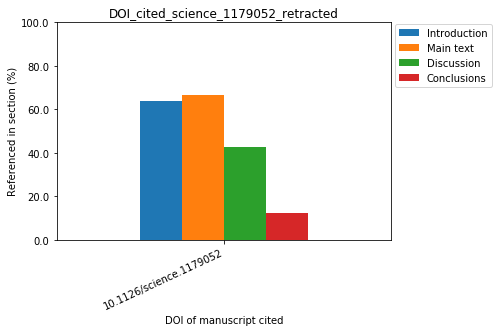

In [6]:

# Reading the pd_citation_hyst from file:
pd_citation_hyst = pd.read_csv(
    analysis_hist_tsv,
    sep='\t',
    encoding='utf-8'
)

figure = (
    pd_citation_hyst
    .set_index('DOI_cited')
    [['cited_in_introduction', 'cited_in_maintext','cited_in_discussion', 'cited_in_conclusions']]
    .plot(kind='bar')
)
plt.xticks(rotation=25, ha ='right')
plt.xlabel("DOI of manuscript cited")
plt.ylabel("Referenced in section (%)")
figure.yaxis.set_major_formatter(FuncFormatter(lambda y, _: str(y * 100))) 
plt.ylim([0, 1.0])
plt.legend(['Introduction', 'Main text','Discussion', 'Conclusions'], loc='upper right', bbox_to_anchor=(1.314, 1.015), ncol = 1)
plt.title(ds_label)

In [7]:
pd_citation_hyst = pd.read_csv(
    analysis_hist_tsv,
    sep='\t',
    encoding='utf-8'
)                                                              
pd_citation_hyst[['DOI_cited','papers_all_sections_found', 'total_papers_citing']]

,DOI_cited,papers_all_sections_found,total_papers_citing
0,10.1126/science.1179052,33,43


# 3. ANALYSING AND PLOTTING JUST 1 paper

In [8]:
# List of DOIs we will study.
# We will study manuscripts that above a certain number of citations within our dataset.
minimun_number_citations = 10
list_DOIs = df_articles.groupby('DOI_cited').size().pipe(
    lambda df: df[df > minimun_number_citations]
).index.values
print('dois with the required minimum number of citations of %d: %s' % (minimun_number_citations, list_DOIs))

DOI =  list_DOIs[0]

df_articles_citingDOI = df_articles[df_articles['DOI_cited'] == DOI]['article_citing']
list_articles_citingDOI = df_articles_citingDOI.values.tolist()
    
df = get_df_analise_section.get_df(DOI, list_articles_citingDOI)

total_papers = df.shape[0]
# mask1: sections found
mask1 = (df['introduction_found'] == True) & ((df['discussion_found'] == True) )#| (df['conclusions_found'] == True))  
# mask2: the reference is found at least in one section
mask2 = (df['cited_in_introduction'] == True) | (df['cited_in_maintext'] == True) | (df['conclusions_found'] == True) | df['sentence_citing_conclusions'] == True
     
mask = mask1 & mask2
    
papers_all_sections_found = len(df[mask])
print("papers_all_sections_found: ", papers_all_sections_found)

found_in_percentages = (df[mask].select_dtypes(include=['bool']).sum() / papers_all_sections_found).to_dict()
    
pd_citation_hyst = pd.DataFrame([{
    'DOI_cited': DOI,  
   'total_papers_citing': total_papers,
   'papers_all_sections_found': papers_all_sections_found,
    **{
        k: found_in_percentages.get(k, 0)
        for k in {'cited_in_introduction', 'cited_in_maintext', 'cited_in_discussion', 'cited_in_conclusions'}
    }
}])

dois with the required minimum number of citations of 10: ['10.1126/science.1179052']
papers_all_sections_found:  24


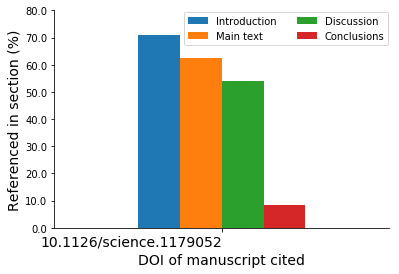

In [9]:
figure = (
    pd_citation_hyst
    .set_index('DOI_cited')
    [['cited_in_introduction', 'cited_in_maintext','cited_in_discussion', 'cited_in_conclusions']]
    .plot(kind='bar')
)
plt.xticks(rotation=0, ha ='right', fontsize=14)
plt.xlabel("DOI of manuscript cited", fontsize=14)
plt.ylabel("Referenced in section (%)", fontsize=14)


figure.spines["top"].set_visible(False)    
figure.spines["bottom"].set_visible(True)    
figure.spines["right"].set_visible(False)    
figure.spines["left"].set_visible(True)    


figure.yaxis.set_major_formatter(FuncFormatter(lambda y, _: str(y * 100))) 

plt.ylim([0, 0.80])
plt.legend(
    ['Introduction', 'Main text','Discussion', 'Conclusions'],
    loc='upper right',
    bbox_to_anchor=(1.013, 1.017),
    ncol=2
)